# Inclusión de un activo libre de riesgo en el portafolio

> Vimos ya técnicas de optimización para obtener la frontera eficiente. También vimos como obtenerla mediante simulación montecarlo.

> En esta clase obtendremos la frontera eficiente de un portafolio que inlcuye un bono (activo libre de riesgo).

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.covariance as skcov
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

## 0. Descargar precios de cierre

In [5]:
def get_historical_closes(ticker, start_date, end_date=None):
    #closes = web.DataReader(name=ticker, data_source='yahoo', start=start_date, end=end_date).sort_index('major_axis')
    closes = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date).read()
    closes.set_axis(closes.loc['date',:,ticker[0]].values, axis=1, inplace=True)
    closes = closes.loc['adjclose'].sort_index().dropna()
    closes = pd.DataFrame(np.array(closes.as_matrix(), dtype=np.float64), columns=ticker, index=closes.index)
    closes.index.name = 'Date'
    return closes
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

Descargar precios de cierre de Apple, Amazon, Microsoft, American Airlines y Coca-Cola, entre el primero de enero del 2016 y hoy.

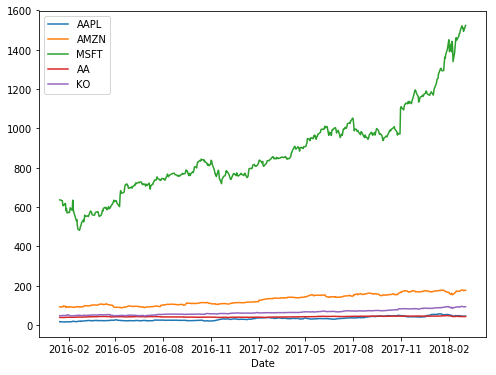

In [6]:
tickers = ['AAPL', 'AMZN', 'MSFT', 'AA', 'KO']
start_date = '2016-01-01'
closes = get_historical_closes(tickers, start_date=start_date)
closes.plot(figsize=(8,6));

## 1. Formulación de riesgo del portafolio

Obtener rendimientos

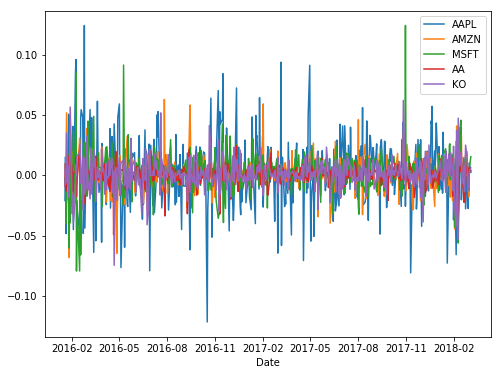

In [7]:
daily_ret = calc_daily_ret(closes)
daily_ret.plot(figsize=(8,6));

Agregar rendimientos fijos del bono...

In [8]:
daily_ret_b = calc_daily_ret(closes)
daily_ret_b.loc[:,'BOND'] = 0.015/252
daily_ret_b

,AAPL,AMZN,MSFT,AA,KO,BOND
Date,,,,,,
2016-01-19,-0.021,-0.005,-5.036e-03,-9.115e-03,-0.008,5.952e-05
2016-01-20,0.015,0.001,-1.800e-03,1.007e-02,0.005,5.952e-05
2016-01-21,-0.048,-0.005,-3.984e-02,-1.297e-02,-0.006,5.952e-05
2016-01-22,-0.023,0.052,-1.465e-03,2.417e-04,0.035,5.952e-05
2016-01-25,0.000,-0.020,1.746e-02,1.606e-02,-0.010,5.952e-05
...,...,...,...,...,...,...
2018-02-27,-0.010,-0.003,-6.572e-03,-9.355e-03,-0.013,5.952e-05
2018-02-28,-0.027,-0.002,3.108e-04,-9.212e-03,-0.005,5.952e-05
2018-03-01,0.002,-0.018,-1.264e-02,4.847e-03,-0.010,5.952e-05


Media

In [9]:
daily_ret_mean = daily_ret.mean()
daily_ret_mean

AAPL    1.897e-03
AMZN    1.250e-03
MSFT    1.700e-03
AA      2.182e-04
KO      1.290e-03
dtype: float64

In [10]:
daily_ret_b_mean = daily_ret_b.mean()
daily_ret_b_mean

AAPL    1.897e-03
AMZN    1.250e-03
MSFT    1.700e-03
AA      2.182e-04
KO      1.290e-03
BOND    5.952e-05
dtype: float64

Covarianza

In [11]:
cov_matrix = daily_ret.cov()
cov_matrix

,AAPL,AMZN,MSFT,AA,KO
AAPL,7.330e-04,-1.025e-05,1.778e-05,-5.130e-06,1.582e-05
AMZN,-1.025e-05,1.812e-04,6.939e-06,7.324e-06,7.205e-05
MSFT,1.778e-05,6.939e-06,2.767e-04,5.927e-06,-1.992e-05
AA,-5.130e-06,7.324e-06,5.927e-06,6.327e-05,1.078e-05
KO,1.582e-05,7.205e-05,-1.992e-05,1.078e-05,1.606e-04


In [12]:
cov_matrix_b = daily_ret_b.cov()
cov_matrix_b

,AAPL,AMZN,MSFT,AA,KO,BOND
AAPL,7.330e-04,-1.025e-05,1.778e-05,-5.130e-06,1.582e-05,-1.322e-38
AMZN,-1.025e-05,1.812e-04,6.939e-06,7.324e-06,7.205e-05,1.469e-39
MSFT,1.778e-05,6.939e-06,2.767e-04,5.927e-06,-1.992e-05,5.877e-39
AA,-5.130e-06,7.324e-06,5.927e-06,6.327e-05,1.078e-05,-3.673e-40
KO,1.582e-05,7.205e-05,-1.992e-05,1.078e-05,1.606e-04,-1.763e-38
BOND,-1.322e-38,1.469e-39,5.877e-39,-3.673e-40,-1.763e-38,7.361e-40


In [14]:
robust_cov_matrix= pd.DataFrame(skcov.ShrunkCovariance().fit(daily_ret).covariance_,columns=daily_ret.columns,index=daily_ret.columns)
robust_cov_matrix

,AAPL,AMZN,MSFT,AA,KO
AAPL,6.866e-04,-9.211e-06,1.597e-05,-4.608e-06,1.421e-05
AMZN,-9.211e-06,1.910e-04,6.233e-06,6.579e-06,6.472e-05
MSFT,1.597e-05,6.233e-06,2.768e-04,5.323e-06,-1.789e-05
AA,-4.608e-06,6.579e-06,5.323e-06,8.508e-05,9.683e-06
KO,1.421e-05,6.472e-05,-1.789e-05,9.683e-06,1.725e-04


In [15]:
robust_cov_matrix_b= pd.DataFrame(np.insert((np.insert(skcov.ShrunkCovariance().fit(daily_ret).covariance_,len(tickers),0,axis=0)),len(tickers),0,axis=1)
,columns=daily_ret_b.columns,index=daily_ret_b.columns)
robust_cov_matrix_b

,AAPL,AMZN,MSFT,AA,KO,BOND
AAPL,6.866e-04,-9.211e-06,1.597e-05,-4.608e-06,1.421e-05,0.0
AMZN,-9.211e-06,1.910e-04,6.233e-06,6.579e-06,6.472e-05,0.0
MSFT,1.597e-05,6.233e-06,2.768e-04,5.323e-06,-1.789e-05,0.0
AA,-4.608e-06,6.579e-06,5.323e-06,8.508e-05,9.683e-06,0.0
KO,1.421e-05,6.472e-05,-1.789e-05,9.683e-06,1.725e-04,0.0
BOND,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.0


## 2. Optimización de portafolios

### Portafolio sin bono

In [16]:
num_portfolios = 200000 # Cantidad de portafolios a simular
r=0.015/252             # Tasa libre de riesgo
num_stocks = len(tickers)

In [17]:
results = np.zeros((num_portfolios, 3+num_stocks)) # Inicialización de vector de resultados

weights = np.random.random((num_portfolios, num_stocks))
weights /= np.sum(weights, axis=1)[:, None]

#Rendimiento y volatilidad
portfolio_return = weights.dot(daily_ret_mean) * 252
portfolio_std_dev = np.zeros(num_portfolios)
for i in range(num_portfolios):
    portfolio_std_dev[i]=np.sqrt(252*(((weights[i,:]).dot(robust_cov_matrix)).dot(weights[i,:].T))) 

#Resultados
results[:,0] = portfolio_return
results[:,1] = portfolio_std_dev
#Sharpe
results[:,2] = (results[:,0]-r) / results[:,1]
#Iteraciones
results[:,3:] = weights

results_frame = pd.DataFrame(results,columns=(['Rendimiento','SD','Sharpe']+list(daily_ret.columns)))
results_frame

,Rendimiento,SD,Sharpe,...,MSFT,AA,KO
0,0.313,0.154,2.028,...,0.119,0.260,0.045
1,0.312,0.130,2.407,...,0.262,0.262,0.227
2,0.317,0.130,2.432,...,0.324,0.156,0.132
3,0.382,0.162,2.356,...,0.409,0.070,0.006
4,0.345,0.162,2.129,...,0.300,0.219,0.168
...,...,...,...,...,...,...,...
199995,0.318,0.131,2.431,...,0.320,0.250,0.099
199996,0.296,0.142,2.086,...,0.157,0.324,0.142
199997,0.296,0.138,2.140,...,0.329,0.348,0.013
199998,0.228,0.111,2.044,...,0.101,0.403,0.160


In [18]:
#Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#Menor SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]

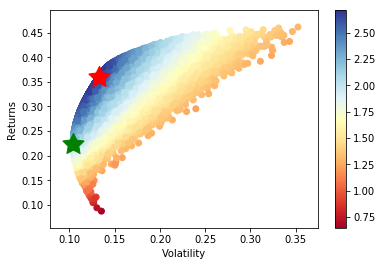

In [19]:
plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500);

In [20]:
max_sharpe_port

Rendimiento    0.359
SD             0.132
Sharpe         2.712
AAPL           0.119
AMZN           0.211
MSFT           0.314
AA             0.053
KO             0.303
Name: 149175, dtype: float64

In [21]:
min_vol_port

Rendimiento    0.224
SD             0.104
Sharpe         2.152
AAPL           0.052
AMZN           0.144
MSFT           0.169
AA             0.463
KO             0.172
Name: 170690, dtype: float64

### Portafolio con bono

In [22]:
num_stocks_b=len(tickers)+1

results = np.zeros((num_portfolios, 3+num_stocks_b)) # Inicialización de vector de resultados

weights_b = np.random.random((num_portfolios,num_stocks_b))
weights_b /= np.sum(weights_b, axis=1)[:, None]
# Es importante ver qué pasa si solo se incluye el bono (no riesgo)
weights_b[0,:]=np.zeros(num_stocks_b) 
weights_b[0,:][-1]=1

#Rendimiento y volatilidad
portfolio_return = weights_b.dot(daily_ret_b_mean) * 252
portfolio_std_dev = np.zeros(num_portfolios)
for i in range(num_portfolios):
    portfolio_std_dev[i]=np.sqrt(252*(((weights_b[i,:]).dot(robust_cov_matrix_b)).dot(weights_b[i,:].T)))

#Resultados
results[:,0] = portfolio_return
results[:,1] = portfolio_std_dev
#Sharpe
results[0, 2] = 0
results[1:,2] = (results[1:,0]-r) / results[1:,1]
#Iteraciones
results[:,3:] = weights_b

results_frame_b = pd.DataFrame(results,columns=(['Rendimiento','SD','Sharpe']+list(daily_ret_b.columns)))
results_frame_b

,Rendimiento,SD,Sharpe,...,AA,KO,BOND
0,0.015,0.000,0.000,...,0.000,0.000,1.000
1,0.190,0.098,1.937,...,0.286,0.053,0.303
2,0.231,0.101,2.292,...,0.145,0.194,0.215
3,0.247,0.098,2.515,...,0.100,0.244,0.235
4,0.256,0.114,2.247,...,0.302,0.160,0.106
...,...,...,...,...,...,...,...
199995,0.283,0.106,2.669,...,0.178,0.257,0.090
199996,0.349,0.155,2.258,...,0.060,0.226,0.059
199997,0.258,0.094,2.738,...,0.052,0.252,0.284
199998,0.221,0.100,2.223,...,0.271,0.280,0.155


In [23]:
#Sharpe Ratio
max_sharpe_port_b = results_frame_b.iloc[results_frame_b['Sharpe'].idxmax()]
#Menor SD
min_vol_port_b = results_frame_b.iloc[results_frame_b['SD'].idxmin()]

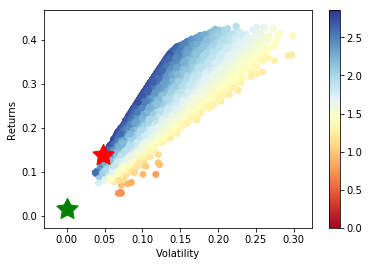

In [24]:
plt.scatter(results_frame_b.SD,results_frame_b.Rendimiento,c=results_frame_b.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port_b[1],max_sharpe_port_b[0],marker=(5,1,0),color='r',s=500);
#Menor SD
plt.scatter(min_vol_port_b[1],min_vol_port_b[0],marker=(5,1,0),color='g',s=500);

In [25]:
max_sharpe_port_b

Rendimiento    0.137
SD             0.048
Sharpe         2.855
AAPL           0.051
AMZN           0.056
MSFT           0.133
AA             0.010
KO             0.085
BOND           0.665
Name: 142909, dtype: float64

In [26]:
min_vol_port_b

Rendimiento    0.015
SD             0.000
Sharpe         0.000
AAPL           0.000
AMZN           0.000
MSFT           0.000
AA             0.000
KO             0.000
BOND           1.000
Name: 0, dtype: float64

In [27]:
results_frame_b.iloc[results_frame_b['Rendimiento'].idxmax()]

Rendimiento    0.431
SD             0.224
Sharpe         1.924
AAPL           0.477
AMZN           0.015
MSFT           0.348
AA             0.008
KO             0.150
BOND           0.001
Name: 129984, dtype: float64

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>